# ID5059 P2 - Credit Card Fraud Detection
180016546, _, _, _, _

#### Plan:
1. Setup
2. Explore data
3. Imputing
4. Balancing
5. Present Models
    1. Decision Tree
    2. Decision Tree with ADA Boosting
    3. Logistic Regression
    4. Logistic Regression with SMOTE
    5. Logistic Regression with Elastic Net
6. Evaluation

### 1. Setup
Import required libraries.

In [8]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn seaborn | grep -v 'already satisfied'

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
%matplotlib inline 

SEED = 618

Defaulting to user installation because normal site-packages is not writeable
distutils: /home/re34/.local/lib/python3.9/site-packages
sysconfig: /home/re34/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


Read in datasets.

In [9]:
# Read in data
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)

train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


Split `train` data into `X` and `y`.

In [10]:
# set id as index
train = train.set_index('id')
test = test.set_index('id')

# split train set into X_train, y_train
y_train = train['Class']
X_train = train.drop('Class', axis = 1)

In [11]:
# Make a function to format results
def output_func(predictions):
    results = pd.DataFrame({'id': test.index, 'Class': predictions[:,1]})
    return results

In [12]:
# Make function to export csv
def export_func (results, filename = 'out'):
    results.to_csv(filename, index = False)

---

### 2. Explore data
Check dataset completeness

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219129 entries, 0 to 219128
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    219129 non-null  float64
 1   V1      219129 non-null  float64
 2   V2      219129 non-null  float64
 3   V3      219129 non-null  float64
 4   V4      219129 non-null  float64
 5   V5      219129 non-null  float64
 6   V6      219129 non-null  float64
 7   V7      219129 non-null  float64
 8   V8      219129 non-null  float64
 9   V9      219129 non-null  float64
 10  V10     219129 non-null  float64
 11  V11     219129 non-null  float64
 12  V12     219129 non-null  float64
 13  V13     219129 non-null  float64
 14  V14     219129 non-null  float64
 15  V15     219129 non-null  float64
 16  V16     219129 non-null  float64
 17  V17     219129 non-null  float64
 18  V18     219129 non-null  float64
 19  V19     219129 non-null  float64
 20  V20     219129 non-null  float64
 21  V21     21

Dataset is complete! All floats except `Class` which is `int`:

In [67]:
train['Class'].unique()

array([0, 1])

`Class` is binary: 0 = no fraud, 1 = fraud. Lets investigate fraud rate in `train`.

In [68]:
# lets just check how much of our train set is fraudulent
fraud = train['Class'].sum()
fraud_percent = fraud/len(train['Class']) * 100

print('fraud:', fraud, '\ntotal entries:', len(train['Class']), '\nfraud rate', round(fraud_percent, 2), '%')

fraud: 469 
total entries: 219129 
fraud rate 0.21 %


Visualise columm value spread.

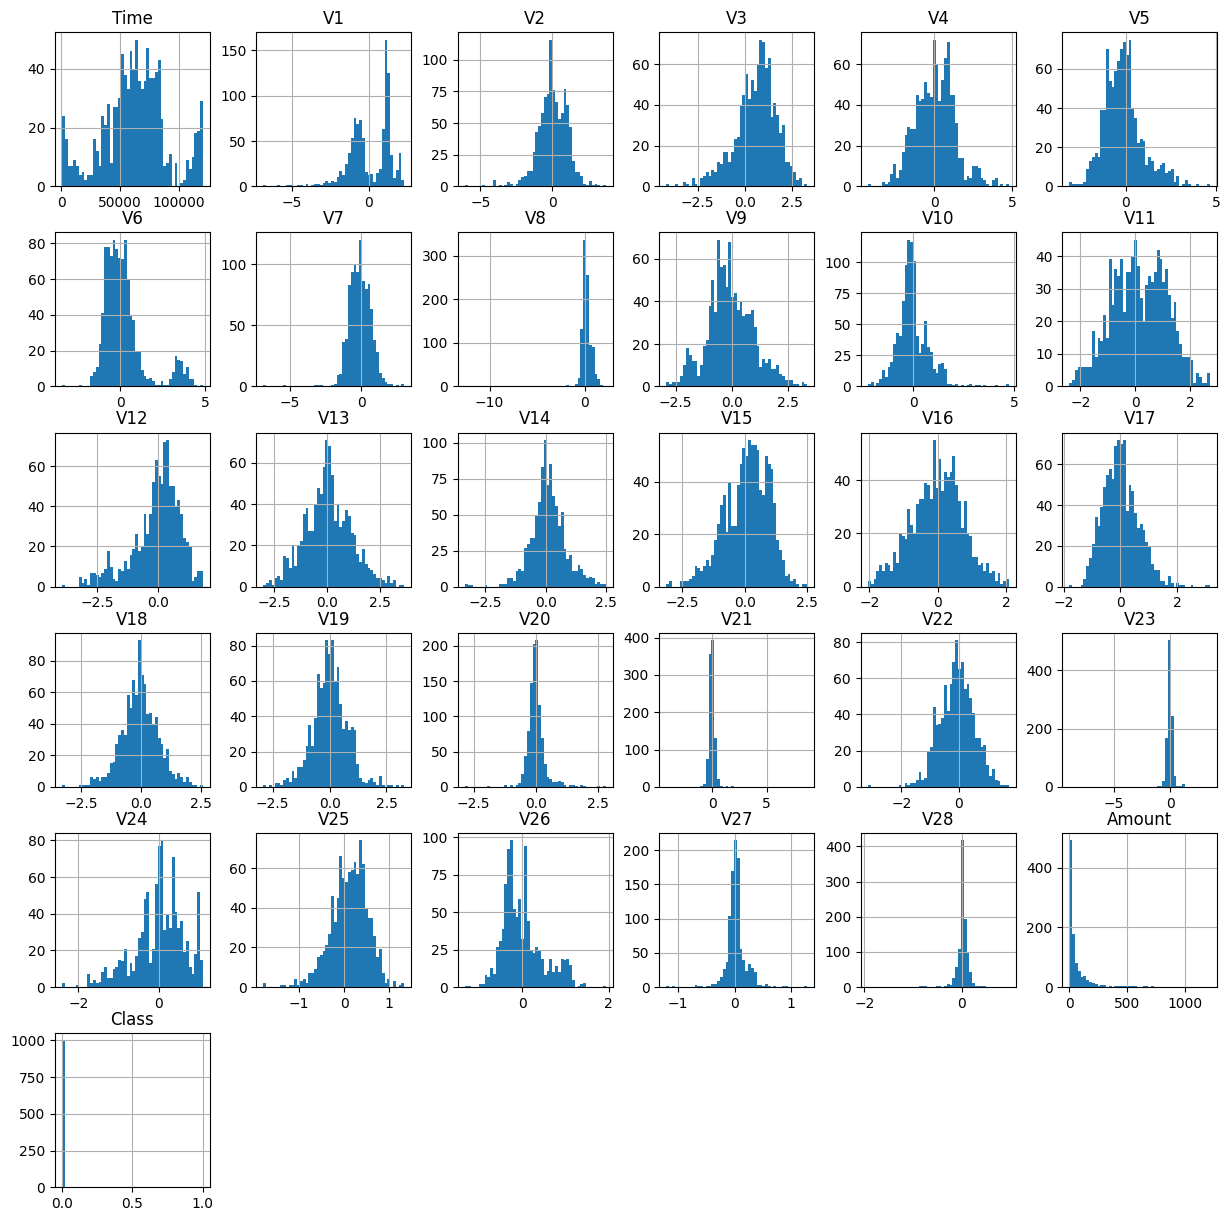

In [69]:
# look at a random subset of data
train_subset = train.sample(1000)
train_subset.hist(bins=50, figsize=(15, 15))
plt.show()

Virtually all columns follow bell curve, meaning fraud cases likely to exist as outliers.

Generate correlation heatmap (TODO: visualise better)

<Axes: >

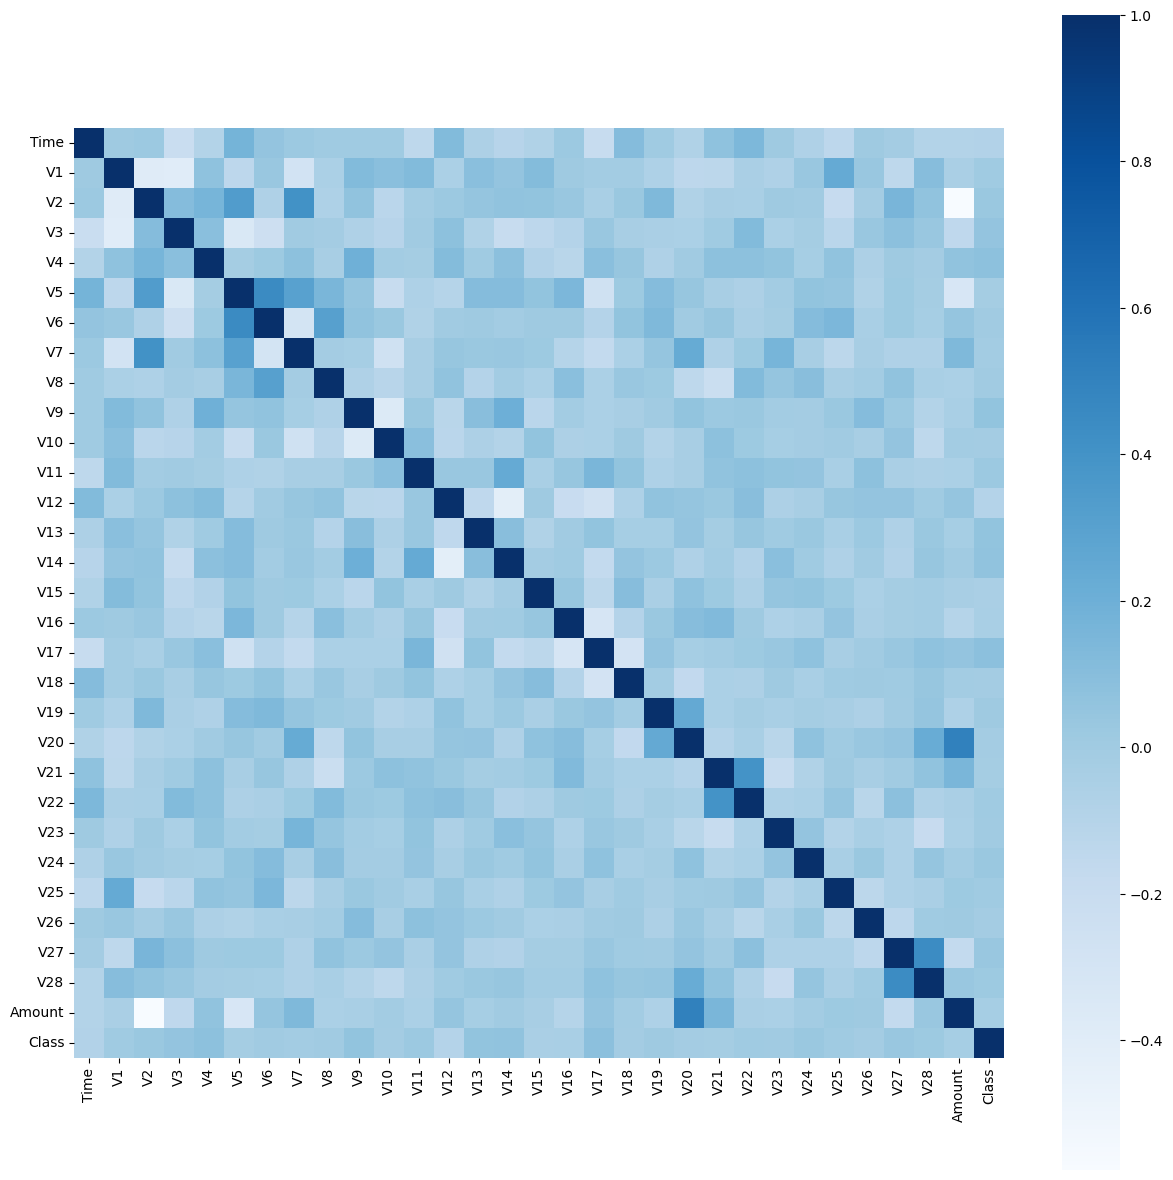

In [70]:
corr = train_subset.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
sb.heatmap(corr, cmap="Blues", ax=ax, square=True)

Focus correlations on `Class`:

In [71]:
cor = train_subset.corr() # correlation coefficients (correlation with price)
pd.DataFrame(abs(cor['Class']).sort_values(ascending=False))

,Class
Class,1.000000
V12,0.092109
V17,0.087143
V4,0.081107
Time,0.079046
V14,0.065942
V9,0.061806
V13,0.061712
V3,0.051621
V15,0.045230


No great correlations present.

---
### 3. Imputing

Since the dataset is already complete we must remove some data first. \
Define method which removes between 10% and 40% of entries in 70% of columns, is seeded.

In [13]:
def remover(df):
  remove_vals = df.copy();
  num_columns = len(remove_vals.columns);
  np.random.seed(SEED)
  rem_columns = round(num_columns * 0.7, 0)
  random_arr = []
  count = 0

  while count < rem_columns :
    r = np.random.randint(1, num_columns - 1);
    if r not in random_arr:
      count += 1;
      random_arr.append(r);

  count = 0;
  for column in remove_vals:
    if count in random_arr:
      random_perc = np.random.uniform(0.1, 0.4);
      cur_mask = np.random.choice([True, False], size= len(remove_vals[column]), p=[random_perc, 1 - random_perc]);
      remove_vals[column] = remove_vals[column].mask(cur_mask);
    count += 1;
      
  return remove_vals

Apply to `X_train`

In [14]:
X_train_remover = remover(X_train)
X_train_remover.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,NaN,0.336701,-0.110835,NaN,0.207733,-0.076576,NaN,1.98
1,0.0,NaN,-1.250891,NaN,-0.894539,-1.122528,-0.270866,NaN,0.050198,-0.109948,0.908773,0.836798,NaN,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,NaN,NaN,-0.461928,-0.465491,-0.464655,NaN,-0.038238,84.00
2,0.0,0.091535,NaN,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,NaN,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,NaN,0.951233,-0.506919,NaN,0.224458,0.087356,2.69
3,0.0,1.979649,-0.184949,NaN,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,NaN,NaN,-0.824356,-0.527267,-0.095838,NaN,0.642659,-0.340089,-0.095514,NaN,NaN,-0.042939,NaN,-0.096148,-0.057780,NaN,1.00
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,NaN,0.692665,-0.097495,1.338869,1.391399,-0.128167,NaN,0.100548,-0.338937,0.090864,-0.423645,-0.731939,NaN,0.099157,0.608908,NaN,-0.262813,NaN,-0.252829,0.108338,NaN,1.00


##### Imputation Methods
Below are three different forms of imputation methods. For analysis of imputation ***SEE FILE***. The methods are as follows:
- Imputation using the Class Mea
- Imputation using an Iterative Imputer: Bayesian Ridge
- Imputation using an Iterative Imputer: Random Forest Regression

In [2]:
#all imports needed for the imputation.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [4]:
#METHOD TO IMPUTE DATA USING CLASS MEAN
def class_mean_imputer(df):
    # compute the mean for each feature and class label
    class_labels = df['Class']
    class_means = []
    for label in np.unique(class_labels):
        class_means.append(df[class_labels == label].mean())

    # impute missing values using class means
    df_class_mean_imputed = SimpleImputer(strategy='mean').fit_transform(df)
    for i in range(len(df)):
        for j in range(len(df.columns)):
            if np.isnan(df_class_mean_imputed[i, j]):
                df_class_mean_imputed[i, j] = class_means[class_labels[i]][j]

    class_mean_imputed = pd.DataFrame(df_class_mean_imputed, index = df.index, columns=df.columns)
    return class_mean_imputed

In [5]:
#METHOD TO IMPUTE DATA USING BAYESIAN RIDGE II
def bayesian_ridge_imputer(df):
    pipeline = Pipeline([('imputer', IterativeImputer(max_iter=20, random_state=0))]) # decide on best parameters?
    df_II_imputed = pd.DataFrame(pipeline.fit_transform(df), columns = df.columns)
    return df_II_imputed


In [16]:
#METHOD TO IMPUTE DATA USING RANDOM FOREST REGRESSION II
def rForest_imputer(df):

    rf_regressor = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, 
                                            max_samples=0.5, n_jobs=2, random_state=0) # tuned hyperparameters
    pipeline = Pipeline([('imputer', IterativeImputer(estimator=rf_regressor, 
                              missing_values=np.nan, 
                              random_state=123))]) 
    df_II_imputed = pd.DataFrame(pipeline.fit_transform(df), columns = df.columns)
    return df_II_imputed


- use random forest iterative imputer to impute data from the removed set

In [17]:
X_train_imputed = rForest_imputer(X_train_remover)

---
### 4. Present models
We trained on basic models before trying to improve results using different methods such as ADA boosting and SMOTE balancing.

#### 4.1. Decision Tree


Using cross validation to find best params for model. 
- `criterion` is being cross validated to find the best splitting method.
- `min_samples_leaf` has been set to 100 to stop overfitting.
- `max_depth` is being cross validated to see if capping the depth stops overfitting.

In [75]:
params = { 
           'criterion':        ['gini', 'entropy'], 
           'min_samples_leaf': [100],
           'max_depth':        [25, None]
         }

clf = GridSearchCV(tree.DecisionTreeClassifier(), params, cv=2)
clf = clf.fit(X_train, y_train)
clf.best_estimator_

DecisionTreeClassifier(max_depth=25, min_samples_leaf=100)

Can use CV results to predict fruad probabilities on entries in the test set (and export to csv)

In [76]:
predictions_test = clf.predict_proba(test)

# Create a new DataFrame with 'id' and 'predicted' columns and export to csv.
predictions_test_fraud_prob = output_func(predictions_test)
export_func(predictions_test_fraud_prob, 'decision_tree.csv')

#### 4.2. Decision Tree with ADA Boosting
After limiting `max_depth` and `min_samples_leaf` the Decision Tree performs pretty well. \
Lets try an alternative method for implementing a Decision Tree by creating a stump and using that with an ADA Boost Classifier to see if that performs better.

Steps:
- Create a simple decision tree fitted with the trianing data 
- The decision tree can be passed into the ADA boost classifier 
- The parameters in ADA boost have been calculated through using GridSearch and cross validation 

In [77]:
decision_tree_simple = DecisionTreeClassifier(max_depth = 1, random_state = SEED);
decision_tree_simple.fit(X_train, y_train)

ada_final = AdaBoostClassifier(decision_tree_simple, n_estimators = 250, algorithm = "SAMME.R", learning_rate = 0.1, random_state = SEED);
ada_final.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=618),
                   learning_rate=0.1, n_estimators=250, random_state=618)

Get the probabilities that each item is fraudulent by using `predict_proba` \
Probabilities are then put into a new dataframe which is formatted for Kaggle

In [78]:
y_probs_ada = ada_final.predict_proba(test)

# Create a new DataFrame with 'id' and 'predicted' columns and export to csv.
ada_prob_results = output_func(y_probs_ada)
export_func(predictions_test_fraud_prob, 'decision_tree_ada.csv')

#### 4.3. Logistic Regression
Logisitic regression requires centered and scaled data.

In [79]:
# Scale the training data
scaler_train = StandardScaler()
X_train_scaled = scaler_train.fit_transform(X_train)

In [80]:
# Create logisitic regression object and fit on scaled train
logi_mod1 = LogisticRegression(random_state=SEED)
logi_train = logi_mod1.fit(X_train_scaled, y_train)

# Do stratified k fold on original train
strat_kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)
logi_train_cv = cross_val_score(logi_train, X_train_scaled, y_train, cv = strat_kfold, scoring='roc_auc')
print(logi_train_cv)

logi_train_meanCV = logi_train_cv.mean()

[0.7761479  0.79780836 0.7891957  0.78904828 0.81151741]


In [81]:
# Scale the test data
X_test_scaled = scaler_train.transform(test)

# Predict on test
predicted_logi_train = logi_train.predict_proba(X_test_scaled)

# Export to csv
logi_train_kaggle = output_func(predicted_logi_train)
export_func(logi_train_kaggle, 'logi_train_kaggle.csv')

#### 4.4. Logistic Regression with Elastic Net

In [82]:
# Scale the training data
scaler_elastic = StandardScaler()
X_elastic_scaled = scaler_elastic.fit_transform(X_train)

In [83]:
# Define the hyperparameter grid
param_grid = { 'l1_ratio': [0.5, 0.9] }

# define logisitc regressor with elastic net
logi_elastic = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100)

# Perform cross-validation grid search
grid_search = GridSearchCV(logi_elastic, param_grid, cv=4)
grid_search.fit(X_elastic_scaled, y_train)

# Choose the best hyperparameters
best_params = grid_search.best_params_
best_params

/Users/harris/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/harris/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/harris/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/harris/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/harris/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/harris/Library/Python/3.8/li

{'l1_ratio': 0.5}

In [84]:
# Train the best model
logi_elastic_train = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, **best_params)
logi_elastic = logi_elastic_train.fit(X_elastic_scaled, y_train)

In [85]:
# Do stratified k fold on SMOTE train
strat_kfold = StratifiedKFold(n_splits = 2, shuffle = True, random_state = SEED)
logi_elastic_cv = cross_val_score(logi_elastic, X_elastic_scaled, y_train, cv = strat_kfold, scoring = 'roc_auc')
print(logi_elastic_cv)

logi_elastic_meanCV = logi_elastic_cv.mean()

[0.79609412 0.78732013]


In [86]:
X_test_elastic_scaled = scaler_elastic.transform(test)

# Predict on elastic test
predicted_logi_elastic = logi_elastic.predict_proba(X_test_elastic_scaled)

# Export to CSV
logi_elastic_kaggle = output_func(predicted_logi_elastic)
export_func(logi_elastic_kaggle, 'logi_elastic_kaggle.csv')

#### 4.5. Logistic Regression with SMOTE balancing
Following the same structure as normal logistic regression, but first we must use SMOTE on the training dataset to oversample fraudulant entries, then balance with an under sampler to balance distribution.

In [87]:
# apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='minority')
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# apply random undersampling to balance the class distribution
rus = RandomUnderSampler(sampling_strategy='majority')
X_train_SMOTE, y_train_SMOTE = rus.fit_resample(X_train_SMOTE, y_train_SMOTE)

In [88]:
# lets just check how much of our resampled set is fraudulent
fraud_bal = y_train_SMOTE.sum()
fraud_percent_bal = fraud_bal / len(y_train_SMOTE) * 100

print('new fraud', fraud_bal, '\ntotal entries', len(y_train_SMOTE), '\nnew fraud rate', fraud_percent_bal, '%')

new fraud 218660 
total entries 437320 
new fraud rate 50.0 %


Now proceed the same as a regular logistic regression but with the new SMOTE datasets.

In [89]:
# Scale the training data
scaler_SMOTE = StandardScaler()
X_SMOTE_scaled = scaler_SMOTE.fit_transform(X_train_SMOTE)

In [90]:
# Create logistic regression object and fit on scaled SMOTE train
logi_mod2 = LogisticRegression(random_state=SEED)
logi_SMOTE = logi_mod2.fit(X_SMOTE_scaled, y_train_SMOTE)

# Do stratified k fold on SMOTE train
strat_kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)
logi_SMOTE_cv = cross_val_score(logi_SMOTE, X_SMOTE_scaled, y_train_SMOTE, cv = strat_kfold, scoring='roc_auc')
print(logi_SMOTE_cv)

logi_SMOTE_meanCV = logi_SMOTE_cv.mean()

[0.86537351 0.86715286 0.86860591 0.86730296 0.86734748]


In [91]:
X_test_SMOTE_scaled = scaler_SMOTE.transform(test)

# Predict on SMOTE test
predicted_logi_SMOTE = logi_SMOTE.predict_proba(X_test_SMOTE_scaled)

# Export to CSV
logi_SMOTE_kaggle = output_func(predicted_logi_SMOTE)
export_func(logi_SMOTE_kaggle, 'logi_SMOTE_kaggle.csv')

---
### 6. Evaluation